In [39]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

CompileError: pyross/forecast.pyx

In [40]:
%matplotlib inline
import numpy as np
import pyross
import pandas as pd
import time 
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [41]:
## population and age classes
M=4  ## number of age classes

my_data = np.genfromtxt('../data/age_structures/UK.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

Ni0=aM+aF;   Ni=np.zeros((M))

# scale the population down to a more manageble level 
Ni[0] = (np.sum(Ni0[0:4])).astype('int')
Ni[1] = (np.sum(Ni0[4:8])).astype('int')
Ni[2] = (np.sum(Ni0[8:12])).astype('int')
Ni[3] = (np.sum(Ni0[12:16])).astype('int')
N=np.sum(Ni)
print(N)
fi = Ni/N 

64111602.0


In [42]:
# Get individual contact matrices
CH0, CW0, CS0, CO0 = pyross.contactMatrix.UK()


CH = np.zeros((M, M))
CW = np.zeros((M, M))
CS = np.zeros((M, M))
CO = np.zeros((M, M))

for i in range(16):
    CH0[i,:] = CH0[i,:]*Ni0[i]
    CW0[i,:] = CW0[i,:]*Ni0[i]
    CS0[i,:] = CS0[i,:]*Ni0[i]
    CO0[i,:] = CO0[i,:]*Ni0[i]


for i in range(M):
    for j in range(M):
        i1, j1 = i*4, j*4
        CH[i,j] = np.sum( CH0[i1:i1+4, j1:j1+4] )/Ni[i]
        CW[i,j] = np.sum( CW0[i1:i1+4, j1:j1+4] )/Ni[i]
        CS[i,j] = np.sum( CS0[i1:i1+4, j1:j1+4] )/Ni[i]
        CO[i,j] = np.sum( CO0[i1:i1+4, j1:j1+4] )/Ni[i]
        
N = N/5e2
Ni = Ni/5e2

In [43]:
# Generate class with contact matrix for SIR-type model with UK contact structure
generator = pyross.contactMatrix.SIR(CH, CW, CS, CO)

def contactMatrix(t):
    return CH + CW + CS + CO

In [44]:
beta  = 0.04         # infection rate
gIa   = 1./7            # recovery rate of asymptomatic infectives
gIs   = 1./7            
gIh   = 1/14
gIc   = 1/14
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter
fh = 0.1 
gE    = 1/5
gA    = 1/3

hh   = 0.1*np.ones(M)       # fraction which goes from Is to hospital
cc   = 0.05*np.ones(M)      # fraction which goes from  hospital to ICU 
mm   = 0.4*np.ones(M)       # mortality from IC
sa = 0  # change in the population, not taken into account by inference at the moment 


# initial conditions
E0   = np.array([10]*M)
A0   = np.array([10]*M)
Ia0  = np.array([10]*M)# each age group has asymptomatic infectives
Is0  = np.array([10]*M)# and also symptomatic infectives
Ih0  = np.array([10]*M)
Ic0  = np.array([10]*M)
Im0  = np.array([2]*M)
R0   = np.zeros(M)
S0   = Ni - (Ia0+Is0+R0+E0+A0+Ih0+Ic0+Im0)

parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,
              'gIh':gIh,'gIc':gIc,  'gE':gE, 'gA':gA,
              'fsa':fsa, 'fh':fh, 
              'sa':sa, 'hh':hh, 'cc':cc, 'mm':mm}
model = pyross.stochastic.SEAI5R(parameters, M, Ni)
print(Ni)

Tf=100;  Nf=Tf+1 

data=model.simulate(S0, E0, A0, Ia0, Is0, Ih0, Ic0, Im0, generator.constant_CM, Tf, Nf)

[31268.886 35668.366 35526.088 25759.864]


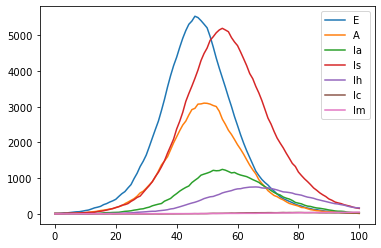

In [45]:
## Save pre intervention traj
data_array = data['X']

np.save('stoch_traj_latent_SEAI5R.npy', data_array)

# plot the stochastic solution 
plt.plot(data['X'][:, M], label='E')
plt.plot(data['X'][:, 2*M], label='A')
plt.plot(data['X'][:, 3*M], label='Ia')
plt.plot(data['X'][:, 4*M], label='Is')
plt.plot(data['X'][:, 5*M], label='Ih')
plt.plot(data['X'][:, 6*M], label='Ic')
plt.plot(data['X'][:, 7*M], label='Im')
plt.legend()
plt.show()

(32,) (101, 32)
(101, 32)


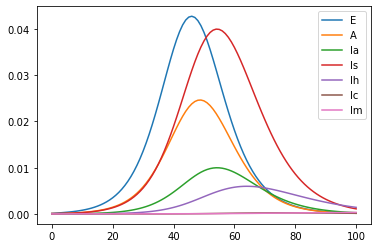

In [46]:
# load the data and rescale to intensive variables 
Tf = 100 # can truncate later 
Nf = Tf+1

x = np.load('stoch_traj_latent_SEAI5R.npy').astype('float')
x = (x/N)[:Nf,:8*M]
steps = 101 # number internal integration steps taken, must be an odd number 


# initialise the estimator 
estimator = pyross.inference.SEAI5R(parameters, M, fi, int(N), steps)

fltr=np.repeat(np.array([False, False, False, False, True, True, True, True]), M)
print(fltr.shape, x.shape)
obs=x[:, fltr] # need to full obs for inference, don't change here 
x0=x[0]

# estimate mean and cov 
det_model = pyross.deterministic.SEAI5R(parameters, int(M), fi)
x_det = estimator.integrate(x[0], 0, Tf, Nf, det_model, contactMatrix)
print(x_det.shape)
plt.plot(x_det[:, M], label='E')
plt.plot(x_det[:, 2*M], label='A')
plt.plot(x_det[:, 3*M], label='Ia')
plt.plot(x_det[:, 4*M], label='Is')
plt.plot(x_det[:, 5*M], label='Ih')
plt.plot(x_det[:, 6*M], label='Ic')
plt.plot(x_det[:, 7*M], label='Im')
plt.legend()
plt.show()

In [38]:
# compute -log_p for the original (correct) parameters 
start_time = time.time() 

## get rid of sussceptibles
#fltr=np.repeat(np.array([False, True, True, True, True, True, True, True, True]), M)


logp = estimator.minus_logp_red(parameters, x0, obs[1:], fltr, Tf, Nf, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

(32,) (101, 16) (32,)


KeyboardInterrupt: 

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj_red'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 531, in pyross.inference.SIR_type.obtain_full_mean_cov
  File "pyross/inference.pyx", line 513, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "/usr/lib/python3.8/site-packages/scipy/integrate/odepack.py", line 242, in odeint
    output = _odepack.odeint(func, y0, t, args, Dfun, col_deriv, ml, mu,
  File "pyross/inference.pyx", line 507, in pyross.inference.SIR_type.estimate_cond_mean_cov.rhs
  File "pyross/inference.pyx", line 877, in pyross.inference.SEAI5R.lyapunov_fun
  File "pyross/inference.pyx", line 592, in pyross.inference.SIR_type.flatten_lyaponuv
  File "<__array_function__ internals>", line 5, in kron
  File "/usr/lib/python3.8/site-packages/numpy/lib/shape_base.py", line 1155, in kron
    result = concatenate(result, axis=axis)
  File "<__array_function__ internals>", line 5, in concatenate
KeyboardInterrupt: 


0.0
90.30581736564636


In [47]:
# make parameter guesses and set up bounds for each parameter 
eps = 1e-4 # step used to calculate hessian in the optimisation algorithm

alpha_g = 0.3          ## bad initial guess
alpha_std = 0.2 
alpha_b = (0.1,0.5)

beta_g  = 0.03         ## bad initial guess
beta_std = 0.1 
beta_b = (1e-3, 1)

gIa_g   = 0.15  
gIa_std = 0.05 
gIa_b = (0.01, 1)

gIs_g   = 0.13 
gIs_std = 0.05 
gIs_b = (0.01, 1)

gE_g    = 0.2
gE_std = 0.05 
gE_b = (0.01, 1)

gA_g    = 0.3 
gA_std = 0.1 
gA_b = (0.01, 1)

# optimisation parameters 
ftol = 1e-5 # the relative tol in (-logp)  

# # set up bounds for the rest of the params 
# # the bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 
bounds = np.array([alpha_bounds, beta_bounds, gIa_bounds, gIs_bounds])
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g])
stds = np.array([alpha_std, beta_std, gIa_std, gIs_std])
start_time = time.time()
params = estimator.latent_inference(guess, stds, obs, fltr, Tf, Nf, generator.constant_CM, bounds, 
                                    global_max_iter=15, global_ftol_factor=1e3, 
                                    verbose=True, ftol=ftol, eps=eps) 
end_time = time.time()
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 4 (seed=423821, Fri May  1 09:29:00 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 inf 1.0e+00 9.14e-01  1e-02  6e-02 0:00.1
    2     32 inf 1.2e+00 1.04e+00  2e-02  7e-02 0:00.2
Optimal value (global minimisation):  inf
Starting local minimisation...


/usr/lib/python3.8/site-packages/cma-3.0.3-py3.8.egg/cma/utilities/utils.py:343: UserWarning: function values with index [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] are not finite but [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]. (class=CMAEvolutionStrategy method=ask )
  warnings.warn(msg + ' (' +
/usr/lib/python3.8/site-packages/cma-3.0.3-py3.8.egg/cma/evolution_strategy.py:3591: RuntimeWarning: invalid value encountered in double_scalars
  current_fitness_range = max(es.fit.fit) - min(es.fit.fit)
/usr/lib/python3.8/site-packages/cma-3.0.3-py3.8.egg/cma/evolution_strategy.py:3592: RuntimeWarning: invalid value encountered in double_scalars
  historic_fitness_range = max(es.fit.hist) - min(es.fit.hist)
/usr/lib/python3.8/site-packages/cma-3.0.3-py3.8.egg/cma/evolution_strategy.py:3597: RuntimeWarning: invalid value encountered in double_scalars
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/lib/py

TypeError: Wrong number or type of arguments for overloaded function 'opt_optimize'.
  Possible C/C++ prototypes are:
    nlopt::opt::optimize(std::vector< double,std::allocator< double > > &,double &)
    nlopt::opt::optimize(std::vector< double,std::allocator< double > > const &)


In [24]:
# save the parameters 
np.save('SEAI5R_latent_param.npy', params)

{'alpha': 0.1726461495874574, 'beta': 0.020130226867684908, 'gIa': 0.12024615891942374, 'gIs': 0.1472697387329405, 'fsa': 0.8}


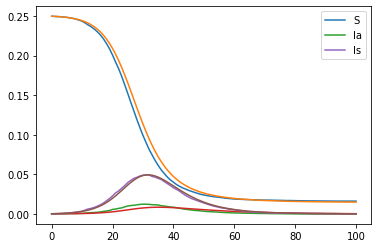

In [25]:
params = np.load('SEAI5R_latent_param.npy')

parameters = estimator.make_params_dict(params)
det_model = pyross.deterministic.SIR(parameters, M, fi)
x_det = estimator.integrate(x[0], 0, Tf, Nf, det_model, generator.constant_CM)
x = data['X']/N

plt.plot(x[:,0], label='S')
plt.plot(x_det[:, 0])
plt.plot(x[:,1*M], label='E')
plt.plot(x_det[:, 1*M])
plt.plot(x[:,2*M], label='A')
plt.plot(x_det[:, 2*M])
plt.plot(x[:,3*M], label='Ia')
plt.plot(x_det[:, 3*M])
plt.plot(x[:,4*M], label='Is')
plt.plot(x_det[:, 4*M])
plt.plot(x[:,5*M], label='Ih')
plt.plot(x_det[:, 5*M])
plt.plot(x[:,6*M], label='Ic')
plt.plot(x_det[:, 6*M])
plt.plot(x[:,7*M], label='Im')
plt.plot(x_det[:, 7*M])
plt.legend()
plt.show()

plt.legend()
plt.show()

guessed initial conditons:  [12480 37479    10    10    10     9]
true initial conditions:  [12480. 37480.] [10 10] [10 10]


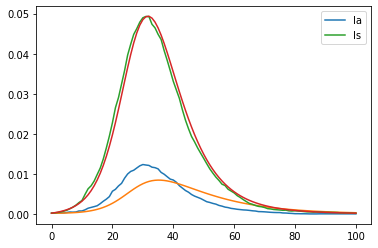

In [26]:
# replot the infected 
print('guessed initial conditons: ', (params[4:]*N).astype('int'))
print('true initial conditions: ', S0, Ia0, Is0)
plt.plot(x[:,1*M], label='Ia')
plt.plot(x_det[:, 1*M])
plt.plot(x[:,2*M], label='Is')
plt.plot(x_det[:, 2*M])
plt.legend()
plt.show()

## Guess with part of the trajectory  

In [4]:
# Cut the observed data 
Tf_small = 20 
Nf_small = Tf_small+1 
steps = 21


x = np.load('latent_SIR_traj.npy').astype('float')/N 
fltr=np.repeat(np.array([False, False, True]), 2)
obs=x[:Nf_small, fltr] # need to full obs for inference, don't change here 
x0 = x[0]

start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
estimator = pyross.inference.SIR(parameters, M, fi, int(N), steps)
logp = estimator.minus_logp_red(parameters, x0, obs[1:], fltr, Tf_small, Nf_small, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-284.4631800683397
0.1596517562866211


In [5]:
# make parameter guesses and set up bounds for each parameter 
eps = 1e-4 # step used to calculate hessian in the optimisation algorithm 
alpha_g = 0.2
alpha_std = 0.1 
alpha_bounds = (eps, 1-2*eps)
# the bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 

beta_g = 0.04
beta_std = 0.05 
beta_bounds = (eps, 1)

gIa_g = 0.145
gIa_std = 0.1 
gIa_bounds = (eps, 1)

gIs_g = 0.145
gIs_std = 0.1 
gIs_bounds = (eps, 1) 

fsa_g = 0.8

Ia0_g = Ia0/N
Ia_std = Ia0_g*0.2 
bounds_for_Ia = np.tile([0.1/N, 100/N], M).reshape(M, 2)


Is0_g = Is0/N 
Is_std = Is0_g*0.1 
bounds_for_Is = np.tile([0.1/N, 100/N], M).reshape(M, 2)

S0_g = S0/N
S_std = Ia_std*np.sqrt(3)
bounds_for_S = np.tile([0.1/N, 1], M).reshape(M, 2)

# optimisation parameters 
ftol = 1e-5 # the relative tol in (-logp)  

# # set up bounds for the rest of the params 
# # the bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 
bounds = np.array([alpha_bounds, beta_bounds, gIa_bounds, gIs_bounds, 
                   *bounds_for_S, *bounds_for_Ia, *bounds_for_Is])
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g, *S0_g, *Ia0_g, *Is0_g])
stds = np.array([alpha_std, beta_std, gIa_std, gIs_std, *S_std, *Ia_std, *Is_std])

ftol=1e-5
start_time = time.time()
params = estimator.latent_inference(guess, stds, obs, fltr, Tf_small, Nf_small, contactMatrix, bounds, 
                                    global_max_iter=20, global_ftol_factor=1e3, 
                                    verbose=True, ftol=ftol, eps=eps) 
end_time = time.time()
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 10 (seed=306018, Thu Apr 30 20:10:24 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 -3.169922880593834e+02 1.0e+00 9.94e-01  7e-06  3e-02 0:02.0
    2     32 -3.454733019219277e+02 1.3e+00 1.04e+00  7e-06  4e-02 0:03.3
    3     48 -3.452730084775375e+02 1.4e+00 1.15e+00  8e-06  4e-02 0:04.5
    6     96 -3.401432204850649e+02 1.8e+00 1.27e+00  9e-06  5e-02 0:07.7
   10    160 -3.474102272231871e+02 2.7e+00 1.21e+00  9e-06  5e-02 0:12.2
   14    224 -3.485072635951567e+02 3.4e+00 1.19e+00  9e-06  4e-02 0:17.4
   20    320 -3.449116908822186e+02 5.1e+00 8.13e-01  6e-06  3e-02 0:23.9
Optimal value (global minimisation):  -349.06639587857023
Starting local minimisation...
Optimal value (local minimisation):  -349.2227064583755
32.51787185668945


best estimates:  [0.08621869 0.0206067  0.06515577 0.16374209]


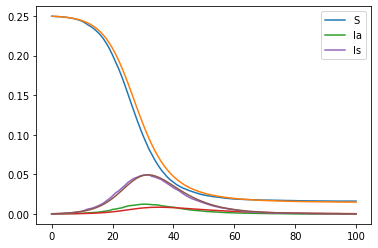

In [6]:
print('best estimates: ', params[:4])
parameters = estimator.make_params_dict(params[:4])
estimator.set_params(parameters)
x0 = params[4:]
det_model = pyross.deterministic.SIR(parameters, int(M), fi)
x_det = estimator.integrate(x0, 0, 100,101, det_model, contactMatrix)
x = np.load('latent_SIR_traj.npy').astype('float')
x = (x/N)
plt.plot(x[:,0], label='S')
plt.plot(x_det[:, 0])
plt.plot(x[:,1*M], label='Ia')
plt.plot(x_det[:, 1*M])
plt.plot(x[:,2*M], label='Is')
plt.plot(x_det[:, 2*M])
plt.legend()
plt.show()

When only the first 20 points are used, the whole trajectory is still well predicted 

In [7]:
hess1, hess2 = estimator.hessian_latent(params, guess, stds, obs[1:], fltr, Tf_small, Nf_small, contactMatrix)
cov1 = np.linalg.inv(hess1) 
cov2 = np.linalg.inv(hess2)

In [10]:
# throws an exception is not positive definite 
np.linalg.cholesky(cov1)
np.linalg.cholesky(cov2)

array([[ 6.92846542e-06,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 8.13043756e-16,  6.92823072e-06,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.11716487e-10, -1.39332648e-11,  4.19783323e-06,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.29082358e-11, -1.84531762e-11, -6.94741256e-09,
         4.18136210e-06,  0.00000000e+00,  0.00000000e+00],
       [-1.04444860e-11, -1.15612389e-12, -1.99214029e-09,
        -7.63691596e-10,  2.10121716e-06,  0.00000000e+00],
       [-2.26662786e-12, -3.47119032e-12, -1.66681916e-09,
        -1.85642932e-09, -4.58736806e-10,  2.09657688e-06]])